In [134]:
import pandas as pd
import nibabel as nib
import numpy as np

from matplotlib import pyplot as plt

from sklearn import svm
from scipy import ndimage

%matplotlib inline


In [121]:
def find_planes(sub_img, sub_seg, visualize=False):
    OUTPUT_PLANES = {}
    for i in range(sub_seg.shape[2]):
        #Take current slice
        cur_plane_seg = sub_seg[:,:,i]
        cur_plane_img = sub_img[:,:,i]
        
        #Seperate to two hemispheres
        right_pts = np.array(np.where(cur_plane_seg ==1.)).T
        left_pts =  np.array(np.where(cur_plane_seg ==3.)).T
        
        #If no points of hemisphere, skip
        if len(left_pts) <= 0 or len(right_pts) <= 0:
            continue
            
        #Create SVM between two hemispheres
        X = np.concatenate([right_pts, left_pts])
        Y = np.array(np.concatenate([[0,]*len(right_pts), [1,]*len(left_pts)]))
        clf = svm.SVC(kernel='linear', C=10, tol=1e-1, max_iter=1e8)
        clf.fit(X, Y)
        
        #Calculate line parameters
        a = -clf.coef_[0][0]/clf.coef_[0][1]
        b = -clf.intercept_/clf.coef_[0][1]
        OUTPUT_PLANES[i] = (float(a), float(b))
        
        print (np.abs(np.linalg.norm(clf.coef_[0])))
        #Visualize if needed
        if visualize:
            plt.figure()
            plt.imshow(cur_plane_img.T)
            plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=plt.cm.Paired, alpha=.005)

            # plot the decision function
            ax = plt.gca()
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()

            # create grid to evaluate model
            xx = np.linspace(xlim[0], xlim[1], 30)
            yy = np.linspace(ylim[0], ylim[1], 30)
            YY, XX = np.meshgrid(yy, xx)
            xy = np.vstack([XX.ravel(), YY.ravel()]).T
            Z = clf.decision_function(xy).reshape(XX.shape)

            # plot decision boundary and margins
            ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                       linestyles=['--', '-', '--'])
            plt.show()    
    return OUTPUT_PLANES

In [23]:
img = nib.load("/mnt/hdd/medica/fetal_data/Fetal_SliceSelect_DB_all/Pat09_Se08_Res0.7422_0.7422_Spac4.nii").get_fdata()
subseg =  nib.load("/mnt/hdd/medica/fetal_data/subseg/Pat09_Se08_Res0.7422_0.7422_Spac4_seg.nii").get_fdata()


In [189]:
img30 = ndimage.rotate(img,40, axes=[0,1])
subseg30 = ndimage.rotate(subseg,40, axes=[0,1], order=0)

0.2572720756479526


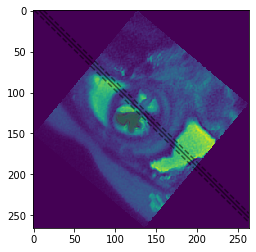

0.9531371296415869


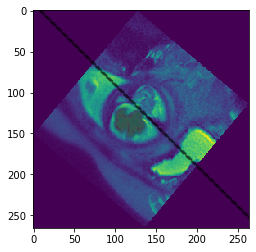

1.1061540700476393


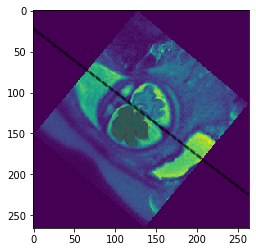

0.9136163465886723


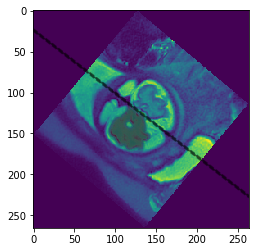

3.5058287141927487


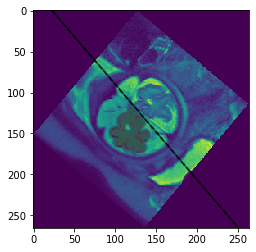

0.2800960210384743


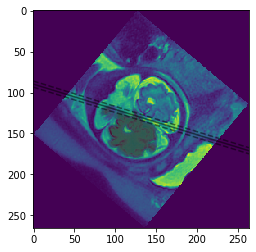

0.6372901187116639


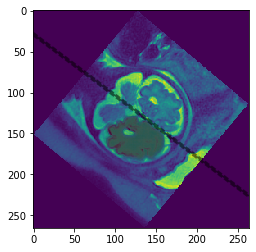

2.885351660199789


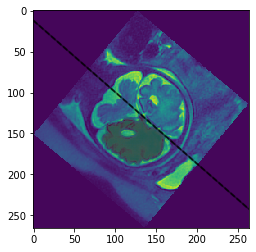

1.4082420725165496


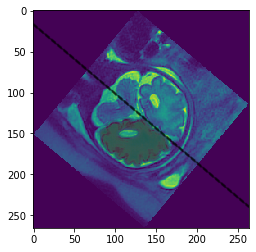

1.6524228117182933


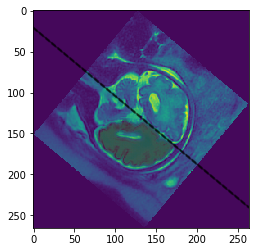

4.122506184174424


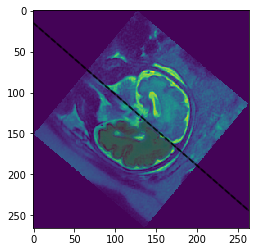

4.948326884184109


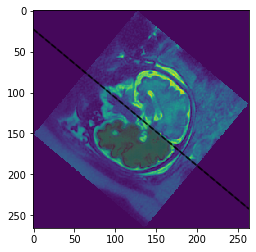

0.4979326383473014


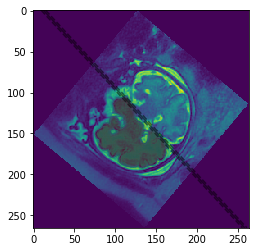

1.585611689722042


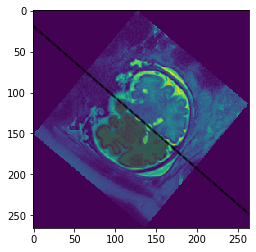

1.923250338625257


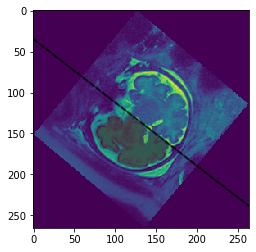

4.99484270105157


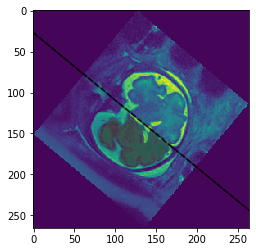

2.492281149244287


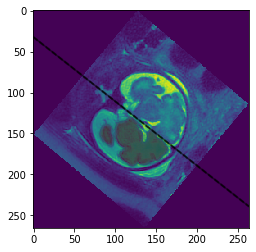

2.252478719513341


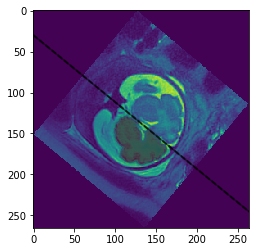

1.999929309646442


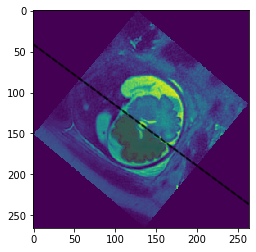

3.2347272221074737


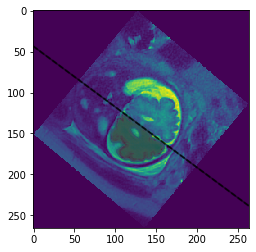

3.817746656218063


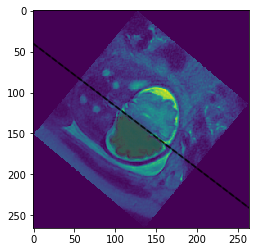

4.086173334851665


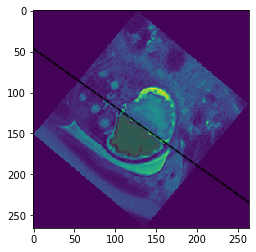

0.9117880437668184


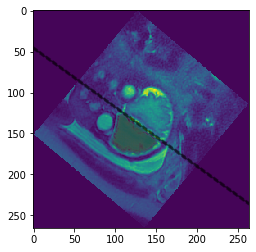

0.9560912788214364


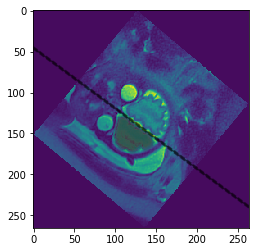

0.4768603927621573


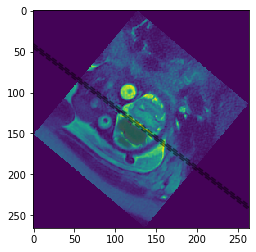

0.14206207246526512


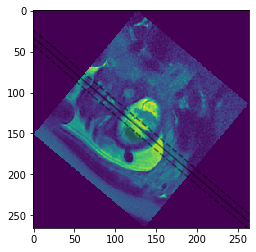

In [190]:
PLANES = find_planes(img30, subseg30, True)

In [195]:
def determine_sides(subseg_plane, a, b, visualize=False):
    # All code assumes segmentation in centralized
    
    # Split to cases
    W, H = subseg_plane.shape
    if np.isinf(a): #Maybe wee should use some threshold a > 1000
        #The MSL is horizontal
        pt_0 = np.array((-b/a, 0))
        pt_1 = np.array((-b/a, H))
        
        pt_c = np.array((-b/a, H/2))
        pt_q = np.array((0, H/2))
        
    elif a == 0: #Same, maybe we should use epsilon
        pt_0 = np.array((0, b))
        pt_1 = np.array((W, b))
        
        pt_c = np.array((W/2, H/2))
        pt_q = np.array((W/2, 0))
    elif np.abs(a) <= 1:
        pt_0 = np.array((0, b)) 
        pt_1 = np.array((W, a*W + b))
        
        pt_c = np.array((W/2, a*(W/2)+ b))
        pt_q = np.array((a*W/2 * (a + 1/a) - a*b, 0))
    else: # np.abs(a) > 1
        pt_0 = np.array((-b/a, 0))
        pt_1 = np.array(((H-b)/a, H))
        
        pt_c = np.array((W/2, a*(W/2)+ b))
        pt_q = np.array((0, W/2 *(a + 1/a) + b))
    
    #Sample points on cerebellum
    pt_on_cerebellum = np.array(np.where(subseg_plane == 2.)).T
    if pt_on_cerebellum.shape[0] == 0:
        return pt_0, pt_1, False
    pt_sample_on_cerebellum = pt_on_cerebellum[np.random.choice(pt_on_cerebellum.shape[0], 5)]

    #Determine sign and quality of segmentation
    pt_sign_all = np.sign(np.cross(pt_c - pt_q, pt_sample_on_cerebellum - pt_q)) > 0
    if all(pt_sign_all):
        pt_0, pt_1 = pt_1, pt_0
    elif all(~pt_sign_all):
        pass
    else:
        print ("Problem")
        return pt_0, pt_1, False
    
    
    if visualize:
        # Visualize
        plt.figure()
        plt.imshow(subseg_plane)
        plt.scatter(pt_0[1], pt_0[0], c='r')
        plt.scatter(pt_1[1], pt_1[0], c='k')
        plt.scatter(pt_q[1], pt_q[0], c='c')    
        print(pt_sign_all)

        #Second way to debug
        for pt_idx in range(pt_sample_on_cerebellum.shape[0]):
            pt = pt_sample_on_cerebellum[pt_idx, :]
            pt_sign = np.cross(pt_c - pt_q, pt - pt_q)
            if  pt_sign > 0:
                plt.scatter(pt[1], pt[0], c='b')
            else:
                plt.scatter(pt[1], pt[0], c='g')
        all_pt = np.stack([pt_0, pt_1]).T
        print(all_pt)
        plt.plot(all_pt[1], all_pt[0], 'b--')
    
    return pt_0, pt_1, True
    

In [272]:
def findMSLforAllPlanes(img, subseg, planes_dict):
    PLANES_MSL = {}
    valid_up_pts = None
    valid_down_pts = None

    #Collect valid planes
    for i in planes_dict.keys():
        PLANES_MSL[i] = determine_sides(subseg[:,:,i], planes_dict[i][0], planes_dict[i][1])
        pt_0, pt_1, isValid = PLANES_MSL[i]
        if not isValid:
            continue
        if valid_up_pts is None:
            valid_up_pts = np.expand_dims(pt_0, axis=0)
            valid_down_pts = np.expand_dims(pt_1, axis=0)
        else:
            valid_up_pts = np.concatenate([valid_up_pts, np.expand_dims(pt_0, axis=0)], axis=0)
            valid_down_pts = np.concatenate([valid_down_pts, np.expand_dims(pt_1, axis=0)], axis=0)

    #Fix with Nearest neighbors
    for i in PLANES.keys():
        pt_0, pt_1, isValid = PLANES_MSL[i]
        if isValid:
            continue
        dist_from_up = np.max(np.linalg.norm(valid_up_pts - pt_0, axis=1))
        dist_from_down = np.max(np.linalg.norm(valid_down_pts - pt_0, axis=1))
        if dist_from_down < dist_from_up:
            #Reverse
            PLANES_MSL[i] = pt_1, pt_0, True
        else:
            PLANES_MSL[i] = pt_0, pt_1, True
    
    return PLANES_MSL

In [273]:
PLANES_MSL = findMSLforAllPlanes(img30, subseg30, PLANES)

/home/netanell/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


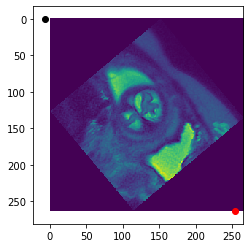

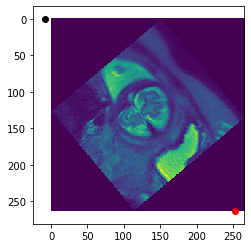

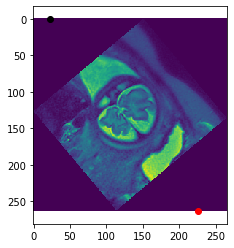

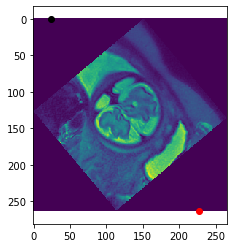

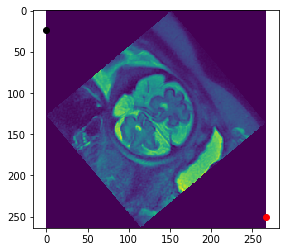

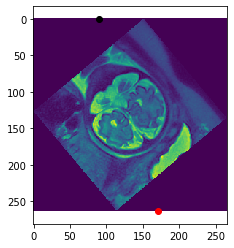

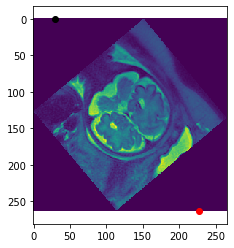

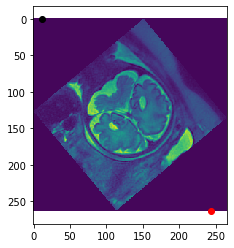

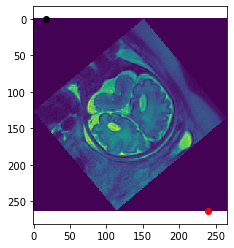

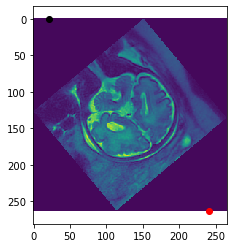

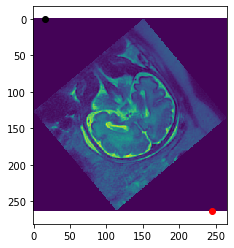

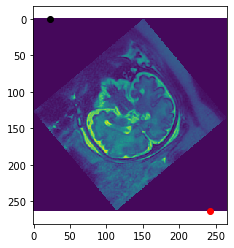

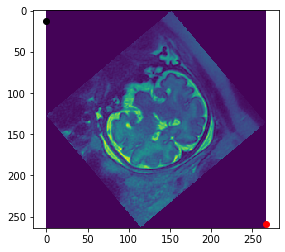

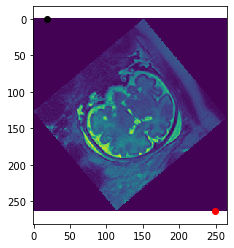

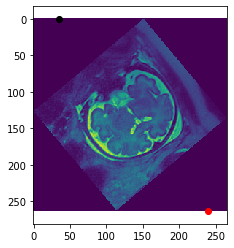

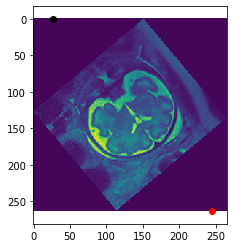

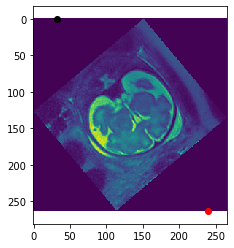

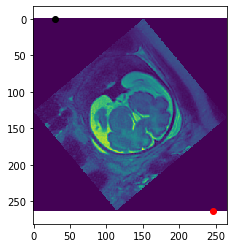

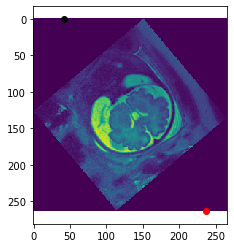

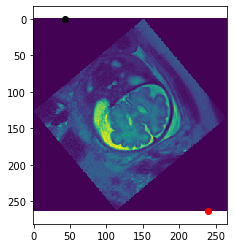

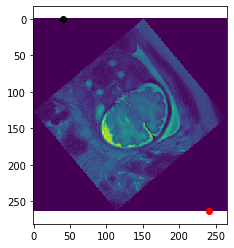

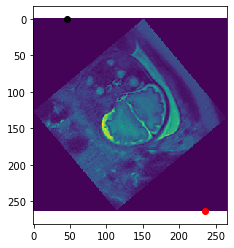

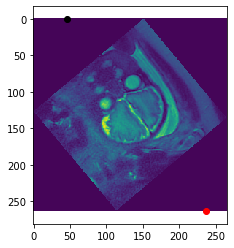

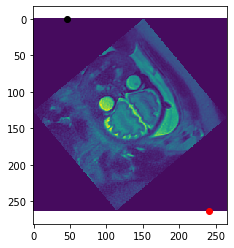

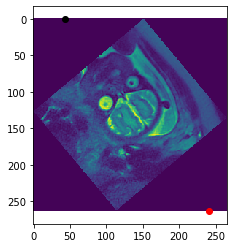

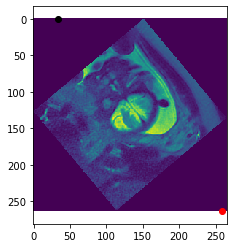

In [274]:
for i in PLANES.keys():
    plt.figure()
    pt_0, pt_1, isValid = PLANES_MSL[i]
    plt.imshow(img30[:,:,i])
    plt.scatter(pt_0[1], pt_0[0], c='r')
    plt.scatter(pt_1[1], pt_1[0], c='k')

In [268]:
np.max(np.linalg.norm(valid_up_pts - pt_0, axis=1))

array([327.47814023, 337.38179831, 335.56784874, 336.07262171,
       338.62603965, 337.21529508])

In [214]:
np.random.randint((1,2))

array([0, 0])

In [220]:
np.concatenate([valid_up_pts, np.random.randint((1,2))], axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)